In [2]:
import imutils
from imutils import face_utils
import time
import dlib
import cv2
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

import torch.utils.data as utils_data
import torch
from torch.optim import Adam, SGD
import torchvision.models as models
import torch.nn as nn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0. Constants

In [3]:
moods = ["anger","disgust","fear","happiness","sadness","surprise","neutral"]
mood_map = { moods[k]:k for k in range(len(moods)) } # mood : index
mood_map.update({ k:moods[k] for k in range(len(moods)) }) # index : mood

# data_path = '/content/drive/MyDrive/Colab Notebooks/FYP70/dataset/fer2013/'
# model_path = '/content/drive/MyDrive/Colab Notebooks/FYP70/models/FCNN_state_dicts/'
data_path = '../dataset/ck/'
model_path = '../models/FCNN_state_dicts/ck/'

# 1. Preparing the Data

### Load CSV

In [4]:
df = pd.read_csv(data_path + 'vector_coords_norm.csv')
df.head()

,emotion,pixels,Usage,vectors,coords
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training,1.0 0.0855595721559356 0.908951992362738 0.053...,0.0 0.05194805194805195 0.0 0.2207792207792207...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training,0.9097354562079145 0.03439099146890885 0.84523...,0.0 0.36363636363636365 0.024390243902439025 0...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training,0.8700982144280447 0.14542327599970098 0.76867...,0.07228915662650602 0.05 0.03614457831325301 0...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training,0.5993885222413324 0.083143088445855 0.5277248...,0.043010752688172046 0.2222222222222222 0.0537...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training,0.9739085450273313 0.06621872273103259 0.88574...,0.0 0.25 0.012345679012345678 0.39473684210526...


### Get DataLoaders

In [5]:
def get_dataloaders(data, label, split_ratio=0.8):
    dataset_size = data.shape[0]
    train_size = int(split_ratio * dataset_size)
    test_size = dataset_size - train_size

    dataset = utils_data.TensorDataset(torch.Tensor(data), torch.LongTensor(label))
    train_set, test_set = utils_data.random_split(dataset, [train_size, test_size])
    batch_size = 64
    train_loader = utils_data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    test_loader = utils_data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)
    print('Data is ready!')
    
    return train_loader, test_loader

In [6]:
%%time
num_samples = df.shape[0]

vectors, coords = [], []
for index, row in df.iterrows():
    vectors.append([float(k) for k in row['vectors'].split(' ')])
    coords.append([float(k) for k in row['coords'].split(' ')])
vectors, coords = np.array(vectors), np.array(coords)

Vector = np.dstack((vectors, coords)).reshape(num_samples, -1) # shape=(samples, vectors+coords)
Label = df.emotion
print(Vector.shape, Label.shape)

train_loader, test_loader = get_dataloaders(Vector, Label)

(35887, 272) (35887,)
Data is ready!
CPU times: user 8.44 s, sys: 220 ms, total: 8.66 s
Wall time: 10.6 s


# 2. Build Model

In [7]:
class FCNNModel(nn.Module):
    def __init__(self, input_layer_size, hidden_layer_size, num_classes):
        super(FCNNModel, self).__init__()
        
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_layer_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, num_classes),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# 3. Training & Evaluation

In [8]:
def evaluate(model, cuda=True): 
    if cuda and torch.cuda.is_available():
        model = model.cuda()

    loss_func = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)      

    model.eval()
    test_acc, test_loss = 0.0, 0.0
    for step, (test_image, test_label) in enumerate(test_loader):
        if cuda and torch.cuda.is_available():
            test_image, test_label = test_image.cuda(), test_label.cuda()                
        test_output = model(test_image)
        _, predicted = torch.max(test_output.data, dim=1)
        test_acc += (predicted == test_label).sum().item()

        batch_loss = loss_func(test_output, test_label)
        test_loss += batch_loss.item()

    test_acc /= len(test_loader.dataset)
    test_loss /= (step+1)

    return {'test_loss': test_loss, 'test_acc': test_acc}

def train(model, cuda=True, epochs=20, print_epoch=50, best_acc=0):

    history = []
    best_state = model.state_dict()

    if cuda and torch.cuda.is_available():
        model = model.cuda()

    loss_func = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)      
    
    train_accs, test_accs = [], []
    for epoch in range(epochs):
        # Training Phase
        train_acc, train_loss = 0.0, 0.0
        for step, (batch_image, batch_label) in enumerate(train_loader):
            model.train()
            if cuda and torch.cuda.is_available():
                batch_image, batch_label = batch_image.cuda(), batch_label.cuda()
            batch_output = model(batch_image)
            batch_loss = loss_func(batch_output, batch_label)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += batch_loss.item()
            _, train_predicted = torch.max(batch_output.data, 1)
            train_acc += (train_predicted == batch_label).sum().item()

        # Validation Phase
        result = evaluate(model, cuda)
        result['train_loss'] = train_loss / (step+1)
        result['train_acc'] = train_acc / len(train_loader.dataset)
        history.append(result)  

        if (not ((epoch+1) % print_epoch)) or ((epoch+1) == epochs):
            print('epoch=%d' % (epoch+1) + (' ' if (epoch+1)<10 else ''), end='')
            print('\ttrain loss=%.5f\ttest loss=%.5f\ttrain accuracy=%.3f\ttest accuracy=%.3f' %
                (result['train_loss'], result['test_loss'], result['train_acc'], result['test_acc']))

        if result['test_acc'] > best_acc:
            best_state = model.state_dict()
            best_acc = result['test_acc']
    
    return history, best_state

In [ ]:
# Create new model
fcnn = FCNNModel(Vector.shape[1], 128, 7) # input, hidden, output
history = [evaluate(fcnn)]
print(history)

[{'test_loss': 1.967277838065561, 'test_acc': 0.05572582892170521}]


In [ ]:
# Load new model
state = torch.load(model_path + 'FCNN.pt', map_location='cpu')
fcnn.load_state_dict(state['state_dict'])
history = state['history']
print(len(history))

100


In [ ]:
%%time
history_one_cycle, best_state = train(fcnn, cuda=True, epochs=100, print_epoch=10, best_acc=max([x['test_acc'] for x in history]))
history = ([] if len(history)==1 else history) + history_one_cycle

epoch=0 	train loss=1.30586	test loss=1.35548	train accuracy=0.497	test accuracy=0.482
epoch=10	train loss=1.30656	test loss=1.37989	train accuracy=0.501	test accuracy=0.480
epoch=20	train loss=1.29398	test loss=1.35261	train accuracy=0.503	test accuracy=0.479
epoch=30	train loss=1.28389	test loss=1.33933	train accuracy=0.507	test accuracy=0.494
epoch=40	train loss=1.28507	test loss=1.35935	train accuracy=0.507	test accuracy=0.486
epoch=50	train loss=1.27980	test loss=1.36667	train accuracy=0.509	test accuracy=0.485
epoch=60	train loss=1.27166	test loss=1.34498	train accuracy=0.513	test accuracy=0.488
epoch=70	train loss=1.26401	test loss=1.36220	train accuracy=0.515	test accuracy=0.485
epoch=80	train loss=1.25867	test loss=1.34617	train accuracy=0.521	test accuracy=0.484
epoch=90	train loss=1.25371	test loss=1.36014	train accuracy=0.522	test accuracy=0.483
epoch=99	train loss=1.24970	test loss=1.35446	train accuracy=0.521	test accuracy=0.486
CPU times: user 4min 37s, sys: 449 ms, tota

# 4. Plotting Performance Graphs of the Model

In [13]:
def plot_accuracies(history):
    train_accs = [x['train_acc'] for x in history]
    val_accs = [x['test_acc'] for x in history]
    plt.plot(train_accs, label='Train accuracy')
    plt.plot(val_accs, ':', label='Val accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('Accuracy vs. No. of epochs');

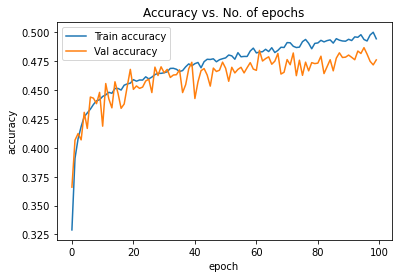

In [ ]:
plot_accuracies(history)

In [14]:
def plot_losses(history):
    train_losses = [x['train_loss'] for x in history]
    val_losses = [x['test_loss'] for x in history]
    plt.plot(train_losses, label='Train loss')
    plt.plot(val_losses, ':', label='Val loss')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title('Loss vs. No. of epochs');

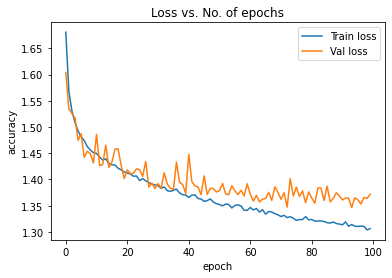

In [ ]:
plot_losses(history)

# 5. Save Model

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/EE4705/'
state = {
    'history': history,
    'state_dict': best_state
}
torch.save(state, model_path + 'FCNN.pt')

# 6. Tuning Hidden Layer Size

In [11]:
hidden_layer_sizes = [16, 32, 64, 128, 256, 512]

### Create/Load Models

In [12]:
models, histories = [], []
for hidden_layer_size in hidden_layer_sizes:
    model = FCNNModel(Vector.shape[1], hidden_layer_size, 7) # input, hidden, output
    models.append(model)
    histories.append([evaluate(model)])

In [ ]:
for i in range(len(hidden_layer_sizes)):
    hidden_layer_size = models[i]
    state = torch.load(model_path + 'FCNN_%d.pt' % hidden_layer_size)
    model[i].load_state_dict(state['state_dict'])
    histories[i] = state['history']

### Training & Evaluation

In [13]:
%%time
best_states = []
for i in range(len(models)):
    print('Hidden layer size: %d' % hidden_layer_sizes[i])
    history = histories[i]
    history_one_cycle, best_state = train(models[i], cuda=True, epochs=500, print_epoch=50, best_acc=max([x['test_acc'] for x in history]))
    histories[i] = ([] if len(history)==1 else history) + history_one_cycle
    best_states.append(best_state)
    print()

Hidden layer size: 16
epoch=50	train loss=1.45385	test loss=1.44139	train accuracy=0.442	test accuracy=0.444
epoch=100	train loss=1.40588	test loss=1.41466	train accuracy=0.463	test accuracy=0.454
epoch=150	train loss=1.38498	test loss=1.39320	train accuracy=0.475	test accuracy=0.467
epoch=200	train loss=1.37703	test loss=1.36541	train accuracy=0.478	test accuracy=0.480
epoch=250	train loss=1.36615	test loss=1.36666	train accuracy=0.480	test accuracy=0.480
epoch=300	train loss=1.35726	test loss=1.37790	train accuracy=0.482	test accuracy=0.471
epoch=350	train loss=1.35281	test loss=1.35954	train accuracy=0.484	test accuracy=0.485
epoch=400	train loss=1.34557	test loss=1.36210	train accuracy=0.486	test accuracy=0.479
epoch=450	train loss=1.34230	test loss=1.36315	train accuracy=0.486	test accuracy=0.476
epoch=500	train loss=1.33765	test loss=1.34730	train accuracy=0.490	test accuracy=0.481

Hidden layer size: 32
epoch=50	train loss=1.42071	test loss=1.41289	train accuracy=0.456	test accu

### Visualizing Performance

In [14]:
eval_dict = {
    'hidden layer size': hidden_layer_sizes,
    'train accuracy': [max([x['train_acc'] for x in k]) for k in histories],
    'test accuracy': [max([x['test_acc'] for x in k]) for k in histories],
}
eval_df = pd.DataFrame(eval_dict)
eval_df.set_index('hidden layer size', inplace=True)
display(eval_df)

,train accuracy,test accuracy
hidden layer size,,
16,0.492145,0.488716
32,0.502316,0.499164
64,0.527047,0.494009
128,0.615347,0.494009
256,0.669790,0.494149
512,0.800829,0.485233


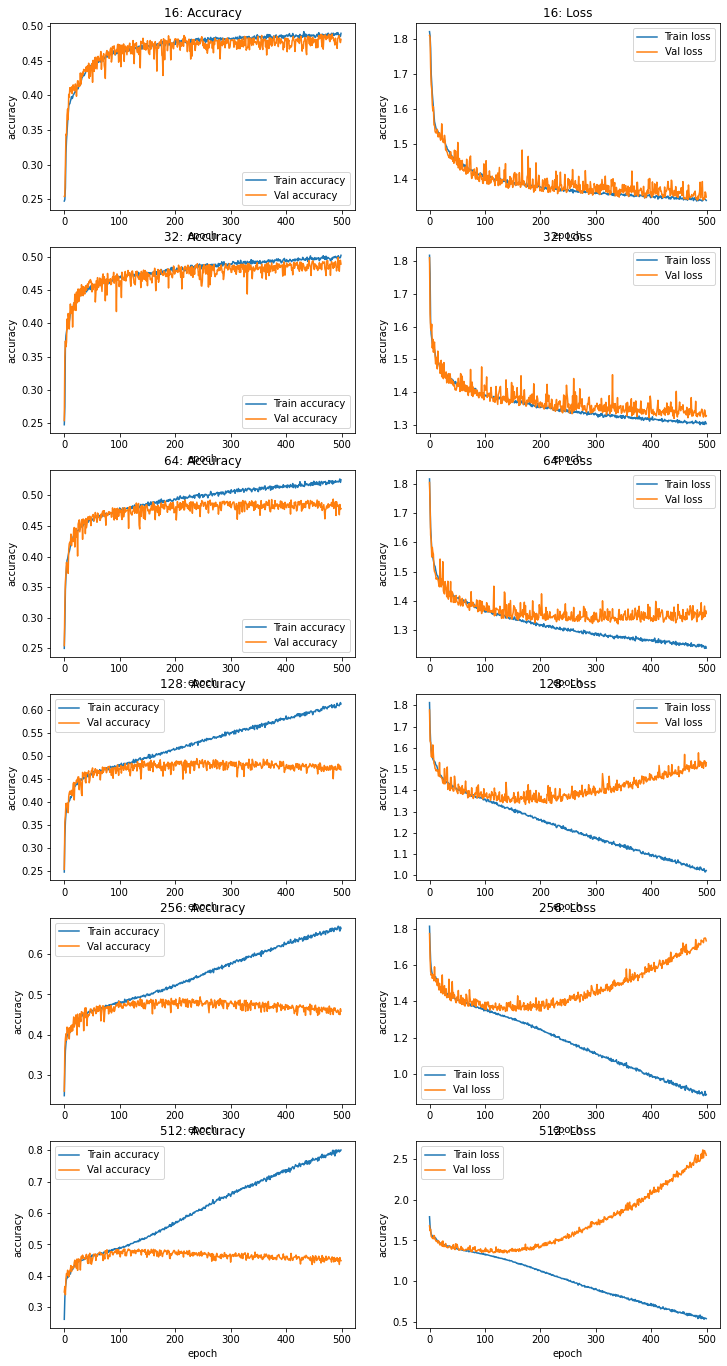

In [15]:
fig = plt.figure(figsize=(12,24))
rows, cols = len(hidden_layer_sizes), 2
for i in range(len(hidden_layer_sizes)):
    history = histories[i]
    fig.add_subplot(rows, cols, i*2+1)
    plot_accuracies(history)
    plt.title('%d: Accuracy' % hidden_layer_sizes[i])
    fig.add_subplot(rows, cols, i*2+2)
    plot_losses(history)
    plt.title('%d: Loss' % hidden_layer_sizes[i])

### Save Models

In [16]:
for i in range(len(hidden_layer_sizes)):
    state = {
        'history': histories[i],
        'state_dict': best_states[i]
    }
    torch.save(state, model_path + 'FCNN_5_layers_%d.pt' % hidden_layer_sizes[i])

# 5. Testing Models

In [ ]:
import random
import math

In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [ ]:
# Functions for finding vector magnitude and direction
def mag(pointA, pointB):
    x = pointA[0] - pointB[0]
    y = pointA[1] - pointB[1]
    return math.sqrt(x*x + y*y)

# find angle between two points (-pi to pi rads)
def angle(cog, point):
    x = point[0] - cog[0]
    y = point[1] - cog[1]
    
    if not x:
        return math.pi/2 if y>0 else -math.pi/2
        
    angle = math.atan(y/x)
    if x<0 and y>0: # 2nd quadrant
        angle += math.pi
    elif x<0 and y<0: # 3rd quadrant
        angle -= math.pi
    return angle

In [ ]:
# get all image filenames
image_filenames = []
for root, dirs, files in os.walk(data_path):
    dirc = os.path.basename(root)
    if dirc != "contempt":
        for file in files:
            image_filenames += [data_path + dirc + '/' + file]        

In [ ]:
# load models
fcnn_model = torch.load('./trained_models/FCNN_model.pt')
fcnn_model.eval()
cnn_model = cnn_models['CNNModel1'].model
cnn_model.eval()

CNNModel(
  (conv1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stat

A: neutral, P(FCNN): neutral, P(CNN): fear


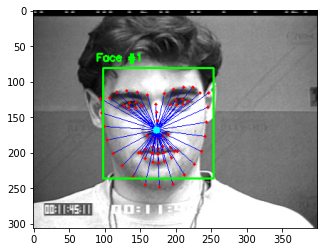

A: neutral, P(FCNN): neutral, P(CNN): fear


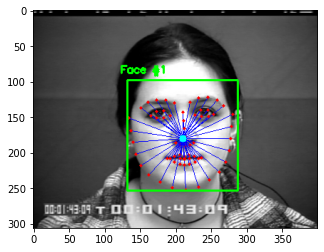

A: happiness, P(FCNN): happiness, P(CNN): fear


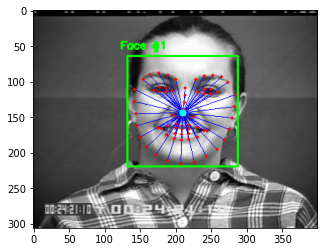

A: neutral, P(FCNN): neutral, P(CNN): fear


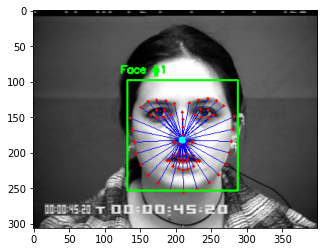

A: fear, P(FCNN): fear, P(CNN): fear


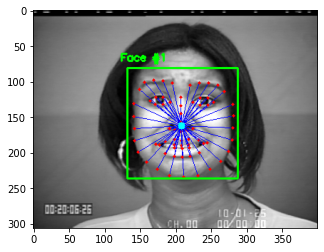

A: happiness, P(FCNN): happiness, P(CNN): fear


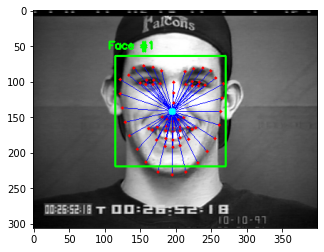

A: neutral, P(FCNN): neutral, P(CNN): fear


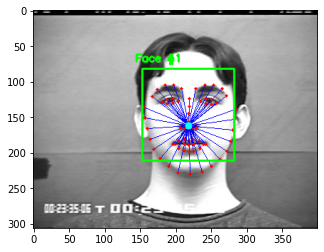

A: happiness, P(FCNN): happiness, P(CNN): fear


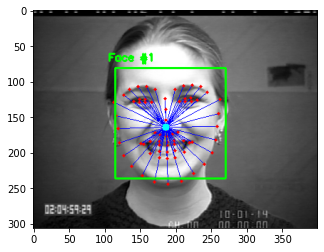

A: anger, P(FCNN): anger, P(CNN): fear


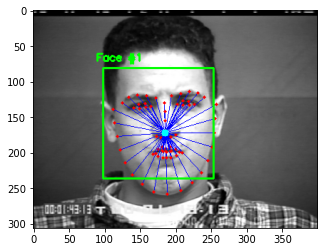

A: neutral, P(FCNN): neutral, P(CNN): fear


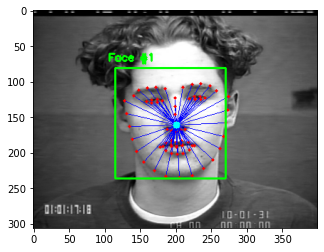

In [ ]:
rand_images = random.sample(image_filenames, 10) # get random images  

for path in rand_images:   
    vectors, coords = [], []

    image = cv2.imread(path)
    image = imutils.resize(image, width=400)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.equalizeHist(gray)
    rects = detector(gray, 1)         

    for (i, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)        

        cog = tuple(shape.mean(axis=0).astype(int)) # get center of gravity (COG)            
        for (x,y) in shape:
            cv2.line(image, (x,y), cog, (0,0,255), 1) # draw vector lines
            cv2.circle(image, (x,y), 2, (255,0,0), -1) # image, center-coords, radius, colour, thickness(fill)
            vectors.append([mag(cog, (x,y)), angle(cog, (x,y))]) # get vector magnitude and direction                
            coords.append([x-cog[0], y-cog[1]]) # append coordinates relative to cog
            cv2.circle(image, cog, 5, (0,255,255), -1)    
            
        (x,y,w,h) = face_utils.rect_to_bb(rect) # convert dlib's rectangle to a OpenCV-style bounding box [i.e., (x,y,w,h)]
        cv2.rectangle(image, (x,y), (x+w, y+h), (0,255,0), 2) # draw the face bounding box
        cv2.putText(image, "Face #{}".format(i+1), (x-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2) # show face number

    ## vector input
    vectors = np.array(vectors)        
    scale_factor = 1 / max(vectors[:,0])
    vectors[:,0] = vectors[:,0] * scale_factor # normalize magnitudes
    coords = np.array(coords) * scale_factor
    coords = coords.reshape(-1)
    
    ## graylevel input
    dim = 50
    cnn_input = image[y:y+h, x:x+w] # crop to face
    cnn_input = cv2.cvtColor(cnn_input, cv2.COLOR_RGB2GRAY) # convert to grayscale
    cnn_input = cv2.equalizeHist(cnn_input) # equalize histogram
    cnn_input = imutils.resize(cnn_input, width=int(dim*1.05)) # buffer of 5 pixels for cropping to 100x100
    cnn_input = cnn_input[:dim,:dim]
    cnn_input = cnn_input.reshape(1,1,dim,dim) # shape=(1,1,dim,dim)
    
    # prediction
    fcnn_input = np.dstack((vectors.reshape(1, -1), coords)).reshape(1, -1) # shape=(1, 272)
    with torch.no_grad():
        fcnn_pred_tensor = fcnn_model(torch.Tensor(fcnn_input).cuda()).argmax()
        fcnn_pred = fcnn_pred_tensor.cpu().numpy().item()
        cnn_pred_tensor = cnn_model(torch.Tensor(cnn_input).cuda()).argmax()
        cnn_pred = cnn_pred_tensor.cpu().numpy().item()        
    fcnn_pred_label = mood_map[fcnn_pred]
    cnn_pred_label = mood_map[cnn_pred]
#     cv2.putText(image, '%s' % pred_label, (x,y+h+20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
    
#     print(path)
    true_label = path.split('/')[2]
    print("A: %s, P(FCNN): %s, P(CNN): %s" % (true_label, fcnn_pred_label, cnn_pred_label))
    plt.imshow(image) # adapted for jupyter
    plt.show()

# 7. Loading Performance Graphs

In [10]:
hidden_layer_sizes = [16, 32, 64, 128, 256, 512]

In [23]:
train_accs, test_accs, = [], []
for i in range(2):
    model_path = '../models/FCNN_state_dicts/fer/' if i else '../models/FCNN_state_dicts/ck/'
    for hls in hidden_layer_sizes:
        state = torch.load(model_path + 'FCNN_norm_%d.pt'%hls, map_location='cpu')
        test_acc = [x['test_acc'] for x in state['history']]
        train_acc = [x['train_acc'] for x in state['history']]
        train_accs.append(max(train_acc))
        test_accs.append(max(test_acc))

In [29]:
eval_df = pd.DataFrame({
    'dataset': ['CK+']*6 + ['FER2013']*6,
    'hidden layer size': hidden_layer_sizes*2,
    'train accuracy': train_accs,
    'test accuracy': test_accs,
})
# eval_df.set_index('hidden layer size', inplace=True)
display(eval_df)

,dataset,hidden layer size,train accuracy,test accuracy
0,CK+,16,0.750347,0.773481
1,CK+,32,0.793343,0.801105
2,CK+,64,0.857143,0.872928
3,CK+,128,0.852982,0.872928
4,CK+,256,0.876560,0.883978
5,CK+,512,0.876560,0.883978
6,FER2013,16,0.485144,0.494567
7,FER2013,32,0.490926,0.502368
8,FER2013,64,0.504685,0.499303
9,FER2013,128,0.517886,0.499582


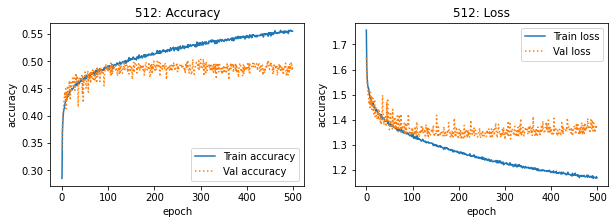

In [16]:
hls = 512
model_path = '../models/FCNN_state_dicts/fer/'
state = torch.load(model_path + 'FCNN_norm_%d.pt'%hls, map_location='cpu')

fig = plt.figure(figsize=(10,3))

history = state['history']
fig.add_subplot(1, 2, 1)
plot_accuracies(history)
plt.title('%d: Accuracy' % hls)
fig.add_subplot(1, 2, 2)
plot_losses(history)
plt.title('%d: Loss' % hls)
plt.show()